# Download the German model for Stanza

Downloading the German model, which includes pre-trained models and resources necessary for tokenization and sentiment analysis in German language.

In [1]:
import stanza 
import pandas as pd

In [2]:
#download models models for tokenization and sentiment analysis in the german language
stanza.download('de', processors='tokenize,sentiment')

#Initialize the pipeline for German language with tokenization and sentiment analysis
nlp = stanza.Pipeline(lang='de', processors='tokenize,sentiment')

2024-05-13 13:40:48 INFO: Downloaded file to /Users/ullasattler/stanza_resources/resources.json
2024-05-13 13:40:48 WARNING: Language de package default expects mwt, which has been added
2024-05-13 13:40:48 INFO: Downloading these customized packages for language: de (German)...
| Processor       | Package      |
----------------------------------
| tokenize        | gsd          |
| mwt             | gsd          |
| sentiment       | sb10k_charlm |
| pretrain        | conll17      |
| forward_charlm  | newswiki     |
| backward_charlm | newswiki     |

2024-05-13 13:40:48 INFO: File exists: /Users/ullasattler/stanza_resources/de/tokenize/gsd.pt
2024-05-13 13:40:48 INFO: File exists: /Users/ullasattler/stanza_resources/de/mwt/gsd.pt
2024-05-13 13:40:48 INFO: File exists: /Users/ullasattler/stanza_resources/de/sentiment/sb10k_charlm.pt
2024-05-13 13:40:48 INFO: File exists: /Users/ullasattler/stanza_resources/de/pretrain/conll17.pt
2024-05-13 13:40:48 INFO: File exists: /Users/ullasatt

2024-05-13 13:40:48 INFO: Downloaded file to /Users/ullasattler/stanza_resources/resources.json
2024-05-13 13:40:48 WARNING: Language de package default expects mwt, which has been added
2024-05-13 13:40:49 INFO: Loading these models for language: de (German):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| sentiment | sb10k_charlm |

2024-05-13 13:40:49 INFO: Using device: cpu
2024-05-13 13:40:49 INFO: Loading: tokenize
2024-05-13 13:40:49 INFO: Loading: mwt
2024-05-13 13:40:49 INFO: Loading: sentiment
2024-05-13 13:40:49 INFO: Done loading processors!


# Import Data

In [3]:
#Read csv 
#nrows just for now for testing-delete later
data = pd.read_csv('../data/subset_studium.csv', sep=';', nrows=700)

In [4]:
#Only use labeled data or rows that are not empty
data = data[data['Studium_Label'].notnull()]

In [5]:
data.head()

,Unnamed: 0,Studium,Studium_Label,Studium_Comment
0,0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn..."
1,1,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...
2,2,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...
3,3,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte..."
4,4,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent..."


In [6]:
#Create copy of data for testing different pos/neutr/neg intervals later
data_copy1= data
data_copy2= data
data_copy3= data
data_copy4= data
data_copy5= data
data_copy6= data

In [7]:
#Put all texts from column Studium in list
column = data["Studium"]
texts = column.tolist()

# Applying Model

It iterates through each text, tokenizes it into sentences, and computes the sentiment score for each sentence. We weights longer sentences more by factoring in the word count of each sentence during sentiment score calculation. The sentiment scores are then aggregated to determine the overall sentiment of each text, where longer sentences have a proportionally higher impact on the sentiment calculation. Finally, the counts of each sentiment category—positive, negative, or neutral—are printed.

negative, neutral, and positive, represented by 0, 1, 2 


In [7]:
def getSentiment (neutr_interv, neg_interv, df):
    total_sentiment = 0
    neg = 0
    pos = 0
    neutr = 0

#iterate through all texts
    for i, text in enumerate(texts):
        doc = nlp(text)
        text_sentiment = 0
        word_count_all = 0

        #iterate through all sentences in one text
        for sentence in doc.sentences:
            word_count = len(sentence.words)
            word_count_all += word_count
            #take longer sentences into consideration and weighing them more
            text_sentiment += (sentence.sentiment * word_count)
    
        total_sentiment = text_sentiment / word_count_all

        #interval for positive label
        if total_sentiment <= 2 and total_sentiment > neutr_interv:
            pos += 1
            sentiment= "positive"
        #interval for neutral label
        elif total_sentiment <= neutr_interv and total_sentiment >= neg_interv:
            neutr += 1
            sentiment= "neutral"
        #interval for negative label
        else:
            neg += 1
            sentiment= "negative"
        #add sentiment as a new column to the df
        df.loc[i, 'Sentiment'] = sentiment

    #print sum 
    print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")


In [24]:
#save the df as a new csv
def saveSentiData(name, data):
    filename = f'{name}_studium_with_sentiment.csv'
    data.to_csv(filename, sep=';', index=True)

In [27]:
#Read the saved sentiment data
def readSentiData(name):
    filename = f'{name}_studium_with_sentiment.csv'
    data_senti = pd.read_csv(filename, sep=';', nrows=700)
    data_senti=data_senti[data_senti['Sentiment'].notnull()]
    data_senti=data_senti[data_senti['Studium_Label'].notnull()]
    return data_senti

In [31]:
#intervals for first run
#Neutral is from 1.3 to 0.8
neutr_interv=1.3
neg_interv=0.8

In [32]:
#run method to get text sentiments
getSentiment(neutr_interv, neg_interv, data)

Neg: 21 Pos: 343 Neutr: 260


In [35]:
#give name for the csv file
name="data1"
#run method to save data as csv
saveSentiData(name, data)

In [38]:
#read sentiment data and print the first few lines
data_senti=readSentiData(name)
data_senti.head()

,Unnamed: 0.1,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0,0.0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",positive
1,1,1.0,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,neutral
2,2,2.0,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3,3.0,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",positive
4,4,4.0,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


## Evaluation 

In [30]:
def calculateMatch(df):
    match_count = (df['Studium_Label'] == df['Sentiment']).sum()
    return match_count

In [39]:
print(calculateMatch(data_senti))

272


In [31]:
def evaluation (data_senti):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
    import matplotlib.pyplot as plt
    data_senti['Studium_Label'] = data_senti['Studium_Label'].astype(str)
    data_senti['Sentiment'] = data_senti['Sentiment'].astype(str)
    confusion_mat = confusion_matrix(data_senti['Studium_Label'], data_senti['Sentiment'], labels=['positive', 'negative', 'neutral'])

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
    disp.plot()
    plt.show()
    print(f1_score(data_senti['Studium_Label'], data_senti['Sentiment'], labels=['positive', 'negative', 'neutral'], average='micro'))
    print(classification_report(
        data_senti['Studium_Label'],
        data_senti['Sentiment'],
        output_dict=False,
        target_names=['positive', 'negative', 'neutral']
    ))

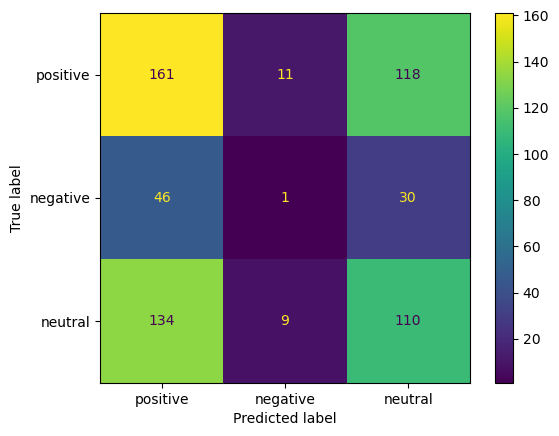

0.4387096774193549
              precision    recall  f1-score   support

    positive       0.05      0.01      0.02        77
    negative       0.43      0.43      0.43       253
     neutral       0.47      0.56      0.51       290

    accuracy                           0.44       620
   macro avg       0.32      0.33      0.32       620
weighted avg       0.40      0.44      0.42       620



In [40]:
evaluation(data_senti)

## Testing different intevals

In [1]:
#Best interval
neutr_interv=1.25
neg_interv=0.85

In [57]:
getSentiment(neutr_interv, neg_interv, data_copy5)
name="data_I5"
saveSentiData(name, data_copy5)

Neg: 33 Pos: 380 Neutr: 211


In [59]:
data_senti=readSentiData(name)
data_senti.head()

,Unnamed: 0.1,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0,0.0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",positive
1,1,1.0,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,neutral
2,2,2.0,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3,3.0,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",positive
4,4,4.0,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


## Evaluation - Different intervals

intervals for damp/boost run
first interval:
neutr_interv=1.3
neg_interv=0.8
-->0.4387

neutr_interv=1.3
neg_interv=0.9
--> 0.4226
____________
neutr_interv=1.4
neg_interv=0.9
--> 0.40 (worse)
-->postive interval shouldnt be that small
____________
neutr_interv=1.3
neg_interv=0.95
--> 0.4226 --> same accuracy as 1.3/0.9, but more positives ranked as negative
--> neg_interv of 0.9 is better
____________
neutr_interv=1.25
neg_interv=0.9
--> 0.4371
____________
neutr_interv=1.25
neg_interv=0.85
--> 0.4451 --> F1 of negatives in contrast to 1.3/0.8 is sligtly worse (0.03)
--> BEST 
____________
neutr_interv=1.3
neg_interv=0.85
--> 0.4306
____________
neutr_interv=1.2
neg_interv=0.85
--> 0.4241

In [60]:
print(calculateMatch(data_senti))

276


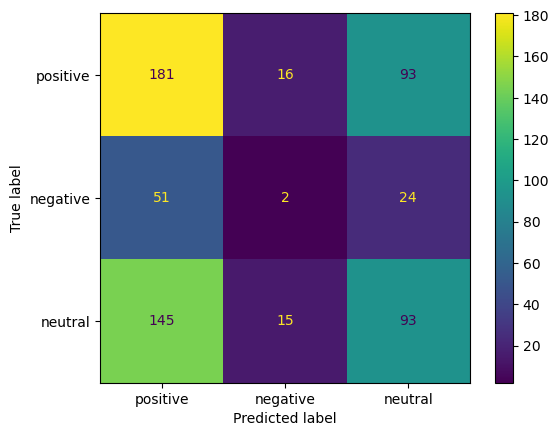

0.44516129032258067
              precision    recall  f1-score   support

    positive       0.06      0.03      0.04        77
    negative       0.44      0.37      0.40       253
     neutral       0.48      0.62      0.54       290

    accuracy                           0.45       620
   macro avg       0.33      0.34      0.33       620
weighted avg       0.41      0.45      0.42       620



In [61]:
evaluation(data_senti)

## Add Dampener and Booster

### TO-DO: 

  (old Booster file)
  1.5/0.5 (and interv 1.3/0.8)
  --> 0.4451
____________________
  1.7/0.2 (and interv 1.25/0.85)
  -->0.446
____________________
  1.7/0.1
  -->0.447
____________________
  1.8/0.1
  -->0.447
____________________
  1.9/0.08
  --> 0.442ne

  (new Booster file)
   1.8/0.1
   -->0.395
____________________
   1.7/0.2
   -->0.405
____________________
   1.5/0.5
   --> 0.415
____________________
   1.4/0.6
   --> 0.423
____________________
   1.4/0.7
   --> 0.424
____________________
   1.5/0.7
   --> 0.424
____________________
   1.6/0.7
   -->0.413
  


In [13]:
# Read the Excel file into a DataFrame
df = pd.read_excel('../data/Booster_Dampner_stanza.xlsx')

# Initialize dictionaries for booster and dampner
booster = {}
dampner = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    booster[row['Booster']] = 1.5  # Assigning a score for each booster
    dampner[row['Dampener']] = 0.7  # Assigning a score for each dampner

#print("Booster Dictionary:")
#print(booster)
#print("\nDampner Dictionary:")
#print(dampner)

In [14]:
from collections import Counter

# Count frequency of booster and dampener words
booster_counts = Counter(booster)
dampner_counts = Counter(dampner)

### TO-DO: mehrere Wörter?

In [21]:
def adjust_sentiment(sentiment_score, words):
    #print(f"Anfang:{sentiment_score}")
    # Überprüfen, ob ein Booster- oder Dämpferwort im Satz vorkommt
    has_booster = any(word.lower() in booster for word in words)
    has_dampener = any(word.lower() in dampner for word in words)

    # Wenn ein Boosterwort vorhanden ist, multipliziere den Sentiment-Score mit dem entsprechenden Wert
    if has_booster:
        booster_word = next((word for word in words if word.lower() in booster), None)
        #print(f"Has Booster {has_booster} : {booster_word}")
        sentiment_score *= max(booster.values())
        #print(f"Boost:{sentiment_score}")
    # Wenn ein Dämpferwort vorhanden ist, multipliziere den Sentiment-Score mit dem entsprechenden Wert
    if has_dampener:
        sentiment_score *= min(dampner.values())
        #print(f"Damp:{sentiment_score}")
    return sentiment_score


In [16]:
def getSentimentBoostDamp(neutr_interv,neg_interv, df):
    total_sentiment = 0
    neg = 0
    pos = 0
    neutr = 0
    for i, text in enumerate(texts):
        doc = nlp(text)
        total_sentiment = 0
        word_count_all = 0
        
        for sentence in doc.sentences:
            word_count = len(sentence.words)
            word_count_all += word_count
        
            sentence_sentiment = sentence.sentiment
            words_in_sentence = [word.text.lower() for word in sentence.words]
            sentiment_score = adjust_sentiment(sentence_sentiment, words_in_sentence) * word_count     
            
            total_sentiment += sentiment_score
            
        # Calculate overall sentiment based on adjusted scores
        average_sentiment = total_sentiment / word_count_all
        
        # Classify sentiment category based on adjusted scores
        if neutr_interv < average_sentiment <= 2.0:
            sentiment = "positive"
            pos+=1
        elif neg_interv <= average_sentiment <= neutr_interv:
            sentiment = "neutral"
            neutr+=1
        else:
            sentiment = "negative"
            neg+=1
        
        df.loc[i, 'Sentiment'] = sentiment
        #print(average_sentiment)
        #print sum 
    print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")
        

In [17]:
#intervals for damp/boost run
neutr_interv=1.25
neg_interv=0.8


In [22]:
getSentimentBoostDamp(neutr_interv, neg_interv, data_copy2)

Neg: 43 Pos: 434 Neutr: 147


In [25]:
name="data3"
saveSentiData(name, data_copy2)

In [28]:
data_senti_boost=readSentiData(name)
data_senti_boost.head()

,Unnamed: 0.1,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0,0.0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",positive
1,1,1.0,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,neutral
2,2,2.0,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3,3.0,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",negative
4,4,4.0,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


In [ ]:
## Evaluation - Booster/Dampner

In [33]:
print(calculateMatch(data_senti_boost))

263


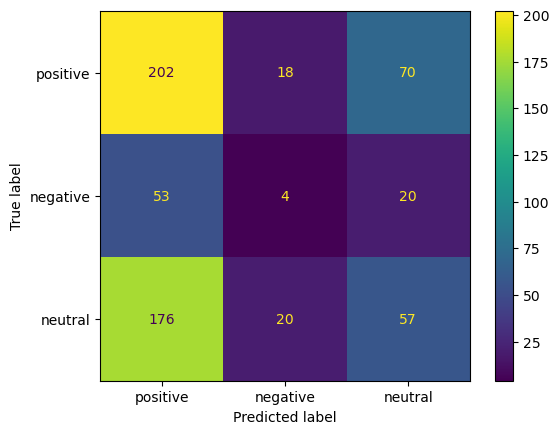

0.4241935483870968
              precision    recall  f1-score   support

    positive       0.10      0.05      0.07        77
    negative       0.39      0.23      0.28       253
     neutral       0.47      0.70      0.56       290

    accuracy                           0.42       620
   macro avg       0.32      0.32      0.30       620
weighted avg       0.39      0.42      0.39       620



In [34]:
evaluation(data_senti_boost)